## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("train.csv").drop(["id", "Row#"], axis=1)
test = pd.read_csv("test.csv").drop(["id", "Row#"], axis=1)
sub = pd.read_csv("sample_submission.csv", index_col=0)

## Feature Selection

In [3]:
class FeatureTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy() 
        data["mean_bee"] = (data["honeybee"] + data["bumbles"] + data["andrena"] + data["osmia"]) / 4
        data["fruitmass_to_seeds"] = data["fruitmass"] / data["seeds"]
        data["fruitmass_to_p"] = data["fruitmass_to_seeds"] ** data["fruitmass"]
        data["round_fruit_set"] = data["fruitset"] / data["seeds"]
        data["fruitset * mean_bee"] = data["mean_bee"] * data["fruitset"]
        data["fruitset / fruitmass"] = data["fruitset"] / data["fruitmass"]
        return data

##### Transformer for pipeline

### Improving prediction values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             15000 non-null  float64
 1   honeybee              15000 non-null  float64
 2   bumbles               15000 non-null  float64
 3   andrena               15000 non-null  float64
 4   osmia                 15000 non-null  float64
 5   MaxOfUpperTRange      15000 non-null  float64
 6   MinOfUpperTRange      15000 non-null  float64
 7   AverageOfUpperTRange  15000 non-null  float64
 8   MaxOfLowerTRange      15000 non-null  float64
 9   MinOfLowerTRange      15000 non-null  float64
 10  AverageOfLowerTRange  15000 non-null  float64
 11  RainingDays           15000 non-null  float64
 12  AverageRainingDays    15000 non-null  float64
 13  fruitset              15000 non-null  float64
 14  fruitmass             15000 non-null  float64
 15  seeds              

<Axes: xlabel='yield', ylabel='Count'>

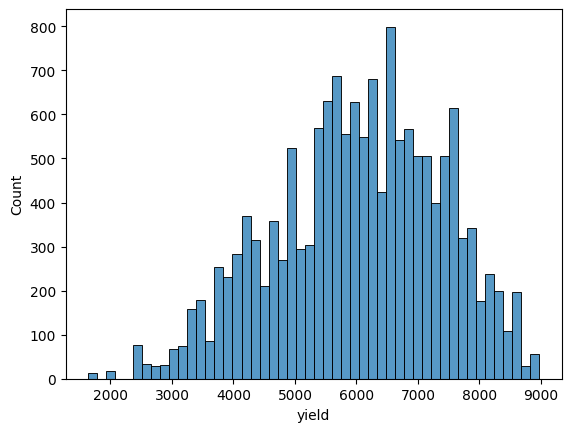

In [5]:
sns.histplot(df["yield"], bins=50)

<Axes: >

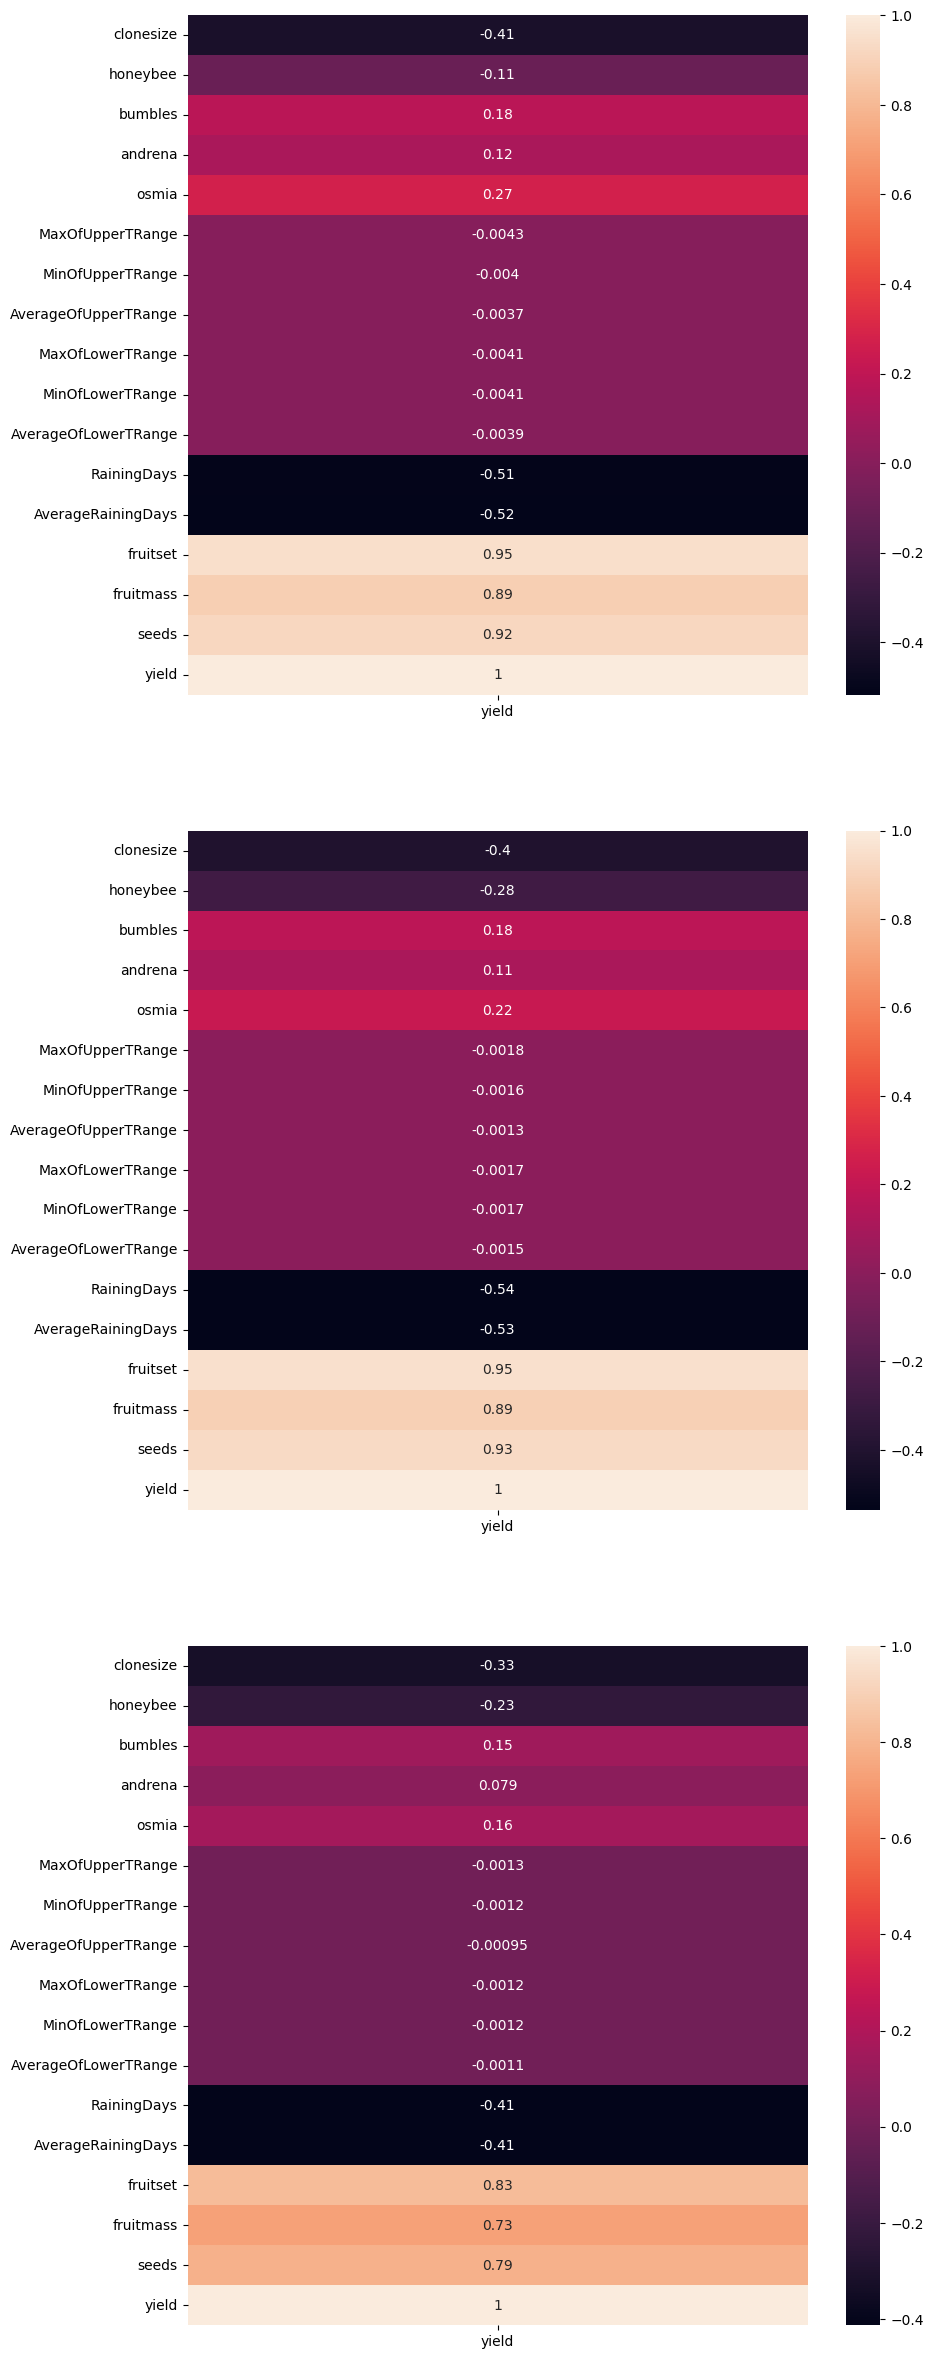

In [6]:
fig, ax = plt.subplots(3, figsize=[10,30])
sns.heatmap(df.corr()[["yield"]], annot=True, ax=ax[0])
sns.heatmap(df.corr(method="spearman")[["yield"]], annot=True, ax=ax[1])
sns.heatmap(df.corr(method="kendall")[["yield"]], annot=True, ax=ax[2])

In [7]:
df.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,19.773500,0.388500,0.284573,0.486751,0.591612,82.245667,49.719033,68.717353,59.282947,28.686927,48.611360,18.804700,0.327261,0.501015,0.445967,36.115335,6022.687345
std,6.644451,0.390162,0.058855,0.147560,0.144194,9.104125,5.519865,7.606632,6.579928,3.180584,5.371006,11.880294,0.166934,0.077379,0.038092,4.121393,1362.796312
min,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,56.800000,50.200000,24.300000,30.000000,1.000000,0.060000,0.029066,0.217545,22.079199,1637.704020
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.451083,0.418220,33.239806,5124.854900
50%,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506225,0.446518,36.040675,6107.382470
75%,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.564795,0.472271,39.099614,7028.673500
max,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,62.000000,34.000000,0.560000,0.960586,0.645475,46.369344,8969.401840


### Unique values

In [8]:
df.nunique()

clonesize                  6
honeybee                   7
bumbles                    9
andrena                   10
osmia                     13
MaxOfUpperTRange           6
MinOfUpperTRange           7
AverageOfUpperTRange       6
MaxOfLowerTRange           5
MinOfLowerTRange           5
AverageOfLowerTRange       9
RainingDays                5
AverageRainingDays         6
fruitset                1084
fruitmass               1112
seeds                   1233
yield                    777
dtype: int64

## Modelling

### Model training

In [9]:
X = df.drop(["yield"], axis=1)
y = df["yield"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

model = RandomForestRegressor(max_depth=11, random_state=42, max_leaf_nodes=163, min_samples_leaf=4, n_estimators=127, criterion="absolute_error", n_jobs=-1)

pipeline = Pipeline([
    ("ft", FeatureTransformer()),
    ("model", model) 
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('ft', FeatureTransformer()),
                ('model',
                 RandomForestRegressor(criterion='absolute_error', max_depth=11,
                                       max_leaf_nodes=163, min_samples_leaf=4,
                                       n_estimators=127, n_jobs=-1,
                                       random_state=42))])

### Model performance evaluation

In [ ]:
pred = pipeline.predict(X_test)

cvs = cross_val_score(model, X,y,cv=5, n_jobs=-1, scoring='neg_mean_absolute_error').mean()
mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred) ** 0.5
r2 = r2_score(y_test, pred)
print(" cross validation score:", -cvs, "\n", "mean absolute error:", mae, "\n", "mean squared error:", rmse, "\n", "r2 score:", r2)

 cross validation score: 239.2958473066404 
 mean absolute error: 238.71432110469829 
 mean squared error: 365.7490366390966 
 r2 score: 0.9281625895863426


### The lines where the mistake occurred were as follows:

In [11]:
errors = np.abs(y_test - pred)  

results = pd.DataFrame()

results['Actual'] = y_test  
results['Prediction'] = pred  
results['Error'] = errors  

results.sort_values(by='Error', ascending=False).head(10)

,Actual,Prediction,Error
9838,1637.70402,6175.128284,4537.424264
3069,1945.53061,5912.894603,3967.363993
6798,8969.40184,5935.245343,3034.156497
2021,1945.53061,4867.263885,2921.733275
8406,1637.70402,4344.729046,2707.025026
10170,1637.70402,3938.729581,2301.025561
13328,1945.53061,4228.779466,2283.248856
13191,8634.77583,6355.916804,2278.859026
12193,1945.53061,4217.616257,2272.085647
6532,6150.84205,3926.627995,2224.214055


## Feature importance

### Alignment of predicted values with actual values

<Axes: xlabel='Actual', ylabel='Prediction'>

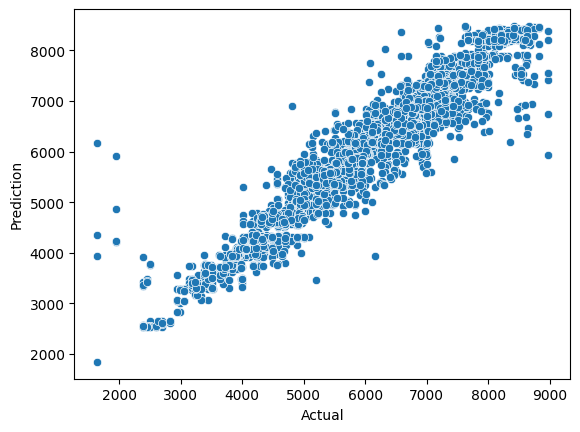

In [12]:
sns.scatterplot(x=results["Actual"], y=results["Prediction"])

##### From this graph, we can see this model good predicts when yield more then 2.000 and less then 8.000

### Columns impact

In [13]:
importance_df = pd.DataFrame({'Feature': model.feature_names_in_, 'Importance': model.feature_importances_})

importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,fruitset,0.802496
1,seeds,0.162119
2,fruitmass_to_p,0.007501
3,round_fruit_set,0.005564
4,fruitmass_to_seeds,0.004048
5,fruitset / fruitmass,0.004023
6,fruitmass,0.003442
7,fruitset * mean_bee,0.002982
8,andrena,0.000849
9,mean_bee,0.000720


 96%|=================== | 4332/4500 [00:25<00:00]       

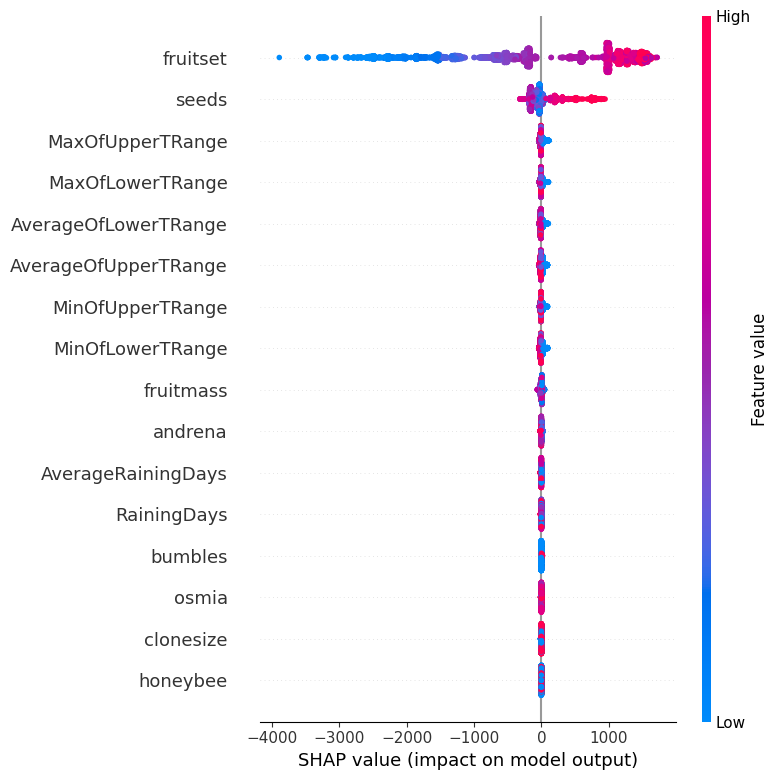

In [14]:
model = pipeline.named_steps['model']

explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

### Learning curve

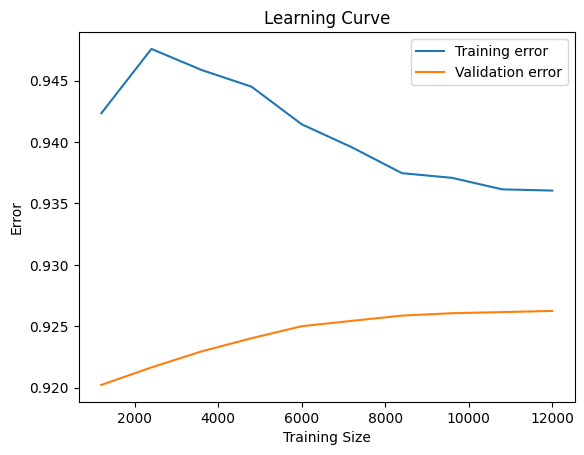

In [16]:
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1,1.0, 10), scoring='r2'
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Validation error')
plt.xlabel('Training Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

##### From this graph, we can see that the training error and validation error are converging.

## Align predictions with actual yield values

In [ ]:
sub["yield"] = model.predict(test)
unique_yield_values = df["yield"].unique()  
sub["yield"] = [unique_yield_values[np.argmin(np.abs(unique_yield_values - p))] for p in sub["yield"]] # Rpund
sub.to_csv("return.csv")

##### NOTE: DON'T USE THIS ROUND FUNCTION IN REAL PROJECTS

### Saving this model

In [ ]:
joblib.dump(pipeline, 'model.pkl')

['model.pkl']